In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [66]:
folder = '036-new-E38-characterization'
ohc14s = [0, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5, 10, 20, 40, 80, 160]
aras = [0, 0.81, 1.625, 3.25, 6.5, 13]

In [51]:
def read_map(plate_map, ctrl_replicate=2, induction_lvl=6):
    
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['group'].apply(lambda x: str(ord(x)- 65))) + '-' + ((plate_map['variable'] - 1) % induction_lvl).astype(str)
    plate_map.loc[plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['variable'] - 1) % ctrl_replicate
    return plate_map[['Well', 'value', 'suffix']].dropna()
    
sample_map = {
    'E38': 'e38x32gp418',
    'BS': 'blank-spec',
    'BK': 'blank-kan',
    'NS': 'negative-control-spec',
    'NK': 'negative-control-kan',
    'mCherry': 'J100-mCherry-kan',
    'GFP': 'J100-GFP-kan'
}

def generate_metadata(well, plate_map, sample_map):
    
    df = pd.merge(well, plate_map, on='Well', how='left').dropna(subset=['value']).reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(str)
    return df.dropna()

def transpose_data(df, col):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index()
    df = df.set_index('index')
    return df

def generate_data(df, name, datapoint=2, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data+1):
        idxs.append(idxs[i-1] + datapoint)
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data):
    
    blank_corrected = data.sub(data[filter(lambda x: x.startswith('blank'), data.columns)].mean(axis=1), axis=0)
    return blank_corrected.drop(filter(lambda x: x.startswith('blank'), blank_corrected.columns), axis=1).reset_index(drop=True)

def get_neg_ctrl_corrected(fluo, od):
    
    blank_corr_fluo = get_blank_corrected(fluo)
    blank_corr_od = get_blank_corrected(od)
    blank_corr_od = blank_corr_od.replace(0, 1e-5)
    data = blank_corr_fluo / blank_corr_od
    
    ### negative control correction because there is no negative control at the moment
    # neg_corrected = data.sub(data[filter(lambda x: x.startswith('negative-control'), data.columns)].mean(axis=1), axis=0)
    # return neg_corrected.drop(filter(lambda x: x.startswith('negative-control'), neg_corrected.columns), axis=1)
    
    return data

In [52]:
plate_map = read_map(pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder)), induction_lvl=12)
raw_data = pd.read_csv('datasets/experiment/{}/raw.csv'.format(folder), skiprows=[0])
metadata = generate_metadata(raw_data['Well'], plate_map, sample_map)
data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
datas = generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/5))

In [53]:
samples = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-kan' not in x, datas[1].columns)],
          datas[0][filter(lambda x: '-kan' not in x, datas[0].columns)])
reporter = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-kan' in x, datas[1].columns)],
           datas[0][filter(lambda x: '-kan' in x, datas[0].columns)])  \
           [filter(lambda x: 'GFP' in x, reporter.columns)]

In [75]:
h = 6
timepoint = 3 * h
samples_t = samples.iloc[timepoint]
   
fluo = samples_t[filter(lambda x: x.startswith('e38x32gp418'), samples_t.index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['ara'] = (fluo_t['gate'].str.split('_', expand=True)[1].str.split('-', expand=True)[0]).astype(int)
fluo_t['ohc14'] = (fluo_t['gate'].str.split('_', expand=True)[1].str.split('-', expand=True)[1]).astype(int)
fluo_pvt = fluo_t.drop('gate', axis=1).pivot('ara', 'ohc14')
fluo_pvt.index = aras
fluo_pvt.columns = ohc14s
fluo_pvt

,0.00000,0.15625,0.31250,0.62500,1.25000,2.50000,5.00000,10.00000,20.00000,40.00000,80.00000,160.00000
0.000,3932.906374,3810.138249,3850.513859,3840.664411,3773.264626,3870.868088,4127.465857,5021.732476,5613.888057,5075.455334,4718.412606,3879.066710
0.810,3590.352505,3564.187939,3553.072626,3320.104830,3526.802218,3574.053243,7603.850426,29701.557407,31510.054845,22414.558059,10048.357994,8811.834320
1.625,4572.905895,4517.960999,4442.026522,4407.292742,4328.416912,4535.240041,7635.194585,47399.395364,70089.798613,62060.834117,36608.638312,32913.270637
3.250,4994.107452,5041.046131,4956.111716,4890.336591,4921.903378,4857.246640,9128.091547,50082.827562,83729.996475,82679.690131,64972.699697,53357.272398
6.500,4191.853826,3980.384464,4146.029356,4093.544646,4107.899807,4154.257350,7177.151679,45455.594002,63647.015202,55445.800962,42999.617298,34872.742545
13.000,4487.766990,4520.204002,4467.583497,4571.654165,4420.594059,4575.674619,8190.663005,55379.186172,73976.874301,66912.533131,57116.883117,45563.208736


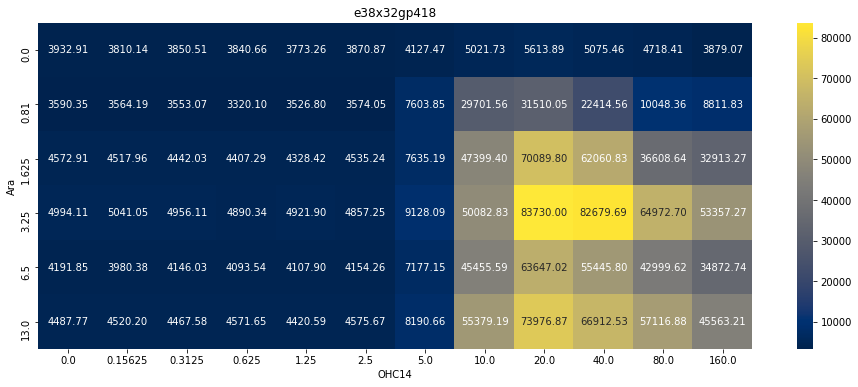

In [76]:
plt.figure(figsize=[16, 6])
sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')
plt.xlabel('OHC14')
plt.ylabel('Ara')
plt.title('e38x32gp418')
plt.show()